<img align="right" width="250" height="150" src="https://lh3.googleusercontent.com/p/AF1QipPWZQfa087JiVjutpUTVEGRnh6W214Wjm439gKQ=w1080-h608-p-no-v0">

## **Proyecto:** Retención de usuarios de la Plataforma Digital

#### El objetivo de este notebook es hacer un análisis de Cohort de los usuarios de plataforma visualizando la adquisición vs. la retención de los mismos.

### Inicializaciones

In [128]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import os
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
#from matplotlib.ticker import FuncFormatter
%matplotlib inline

try:
    # Monto la unidad de drive porque los archivos son muy grandes
    from google.colab import drive
    drive.mount('/content/drive')
    DIR = '/content/drive/MyDrive/Trayecto3-DataDriven/Data/'
except:
    # Sino lo consigo asumo que estoy trabajando local
    DIR = os.path.abspath(r'..\Data\Export') + '\\'

FECHA_INICIO = dt.datetime(2019, 11, 1)

In [129]:
file = DIR + 'Usuarios.parquet'
df = pd.read_parquet(file, columns=['ID_USER', 'FechaCreacion', 'LAST_LOGIN'])

FECHA_MAX = df['LAST_LOGIN'].max()
FECHA_CORTE = FECHA_MAX - relativedelta(months=3)

In [130]:
# Evaluamos si abandono o no la plataforma si hace 90 dias que no accede
df['ABANDONO_PD'] = ((FECHA_MAX - df['LAST_LOGIN']).astype('timedelta64[D]') > 90).astype(int)

### Evaluar la evolución de los usuarios de la plataforma

In [131]:
df_altas = (df.groupby('FechaCreacion').size()).to_frame()
df_altas.columns = ['Cantidad']
df_bajas = (df[df['ABANDONO_PD']==1].groupby('LAST_LOGIN').size()).to_frame()
df_bajas.columns = ['Cantidad']
df_diff = df_altas - df_bajas

In [132]:
df_altas = df_altas.cumsum()
df_bajas = df_bajas.cumsum()
df_diff = df_altas - df_bajas

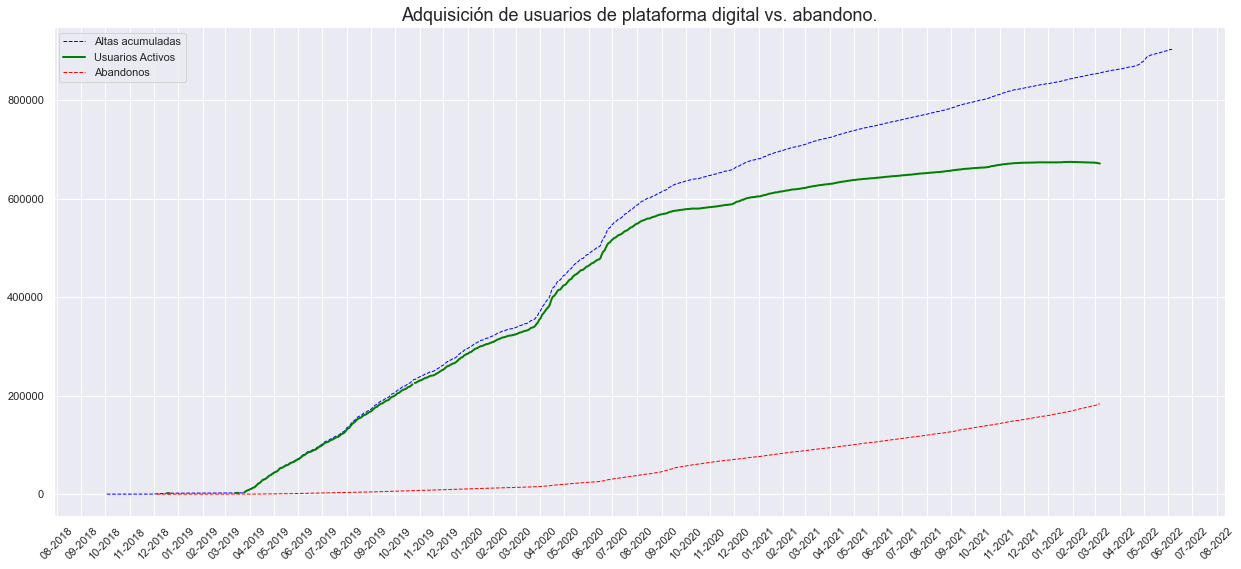

In [133]:
fig, ax = plt.subplots(figsize=(21, 9))
ax.set_title('Adquisición de usuarios de plataforma digital vs. abandono.', fontsize = 18)
ax.plot(df_altas, c='blue', label='Altas acumuladas', linestyle='--', linewidth=1)
ax.plot(df_diff, c='green', label='Usuarios Activos', linewidth=2)
ax.plot(df_bajas, c='red', label='Abandonos', linestyle='--', linewidth=1)
months = MonthLocator()
monthsFmt = DateFormatter('%m-%Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
plt.xticks(rotation=45)
ax.legend()
plt.show(block=False)

In [134]:
# Filtro a partir de cuando quiero hacer el cohorte
df = df[df['FechaCreacion'] >= FECHA_INICIO]

In [135]:
# Creamos la columna cohort_group con el YYYY-MM de onboarding del usuario
df['COHORT_GROUP'] = df['FechaCreacion'].apply(lambda x: x.strftime('%Y-%m'))

In [136]:
# Filtro hasta los creados en la fecha de corte
df = df[df['FechaCreacion'] <= FECHA_CORTE]
# Topeamos la fecha de último login a la fecha de corte
df.loc[df['LAST_LOGIN'] > FECHA_CORTE, 'LAST_LOGIN'] = FECHA_CORTE
# Creamos la columna periodo con el YYYY-MM de la fecha de último logín
df['PER_LLOGIN'] = df['LAST_LOGIN'].apply(lambda x: x.strftime('%Y-%m'))

In [137]:
df_cg = df.groupby(['COHORT_GROUP']).aggregate({'ABANDONO_PD': 'count'})

In [138]:
df_ab = df.groupby(['COHORT_GROUP', 'PER_LLOGIN']).aggregate({'ABANDONO_PD': 'sum'}).groupby('COHORT_GROUP').cumsum()

In [139]:
# Tenemos la matriz con los abandonos y la serie con los totales del cohorte
# Restamos el total del vector de cohortes menos la matriz de abandonos y nos da la matriz de Retención
df_ch = (df_cg - df_ab)

In [140]:
# Ahora la expresamos en %
retencionp = df_ch['ABANDONO_PD'].unstack(1).divide(df_cg.squeeze(), axis=0)

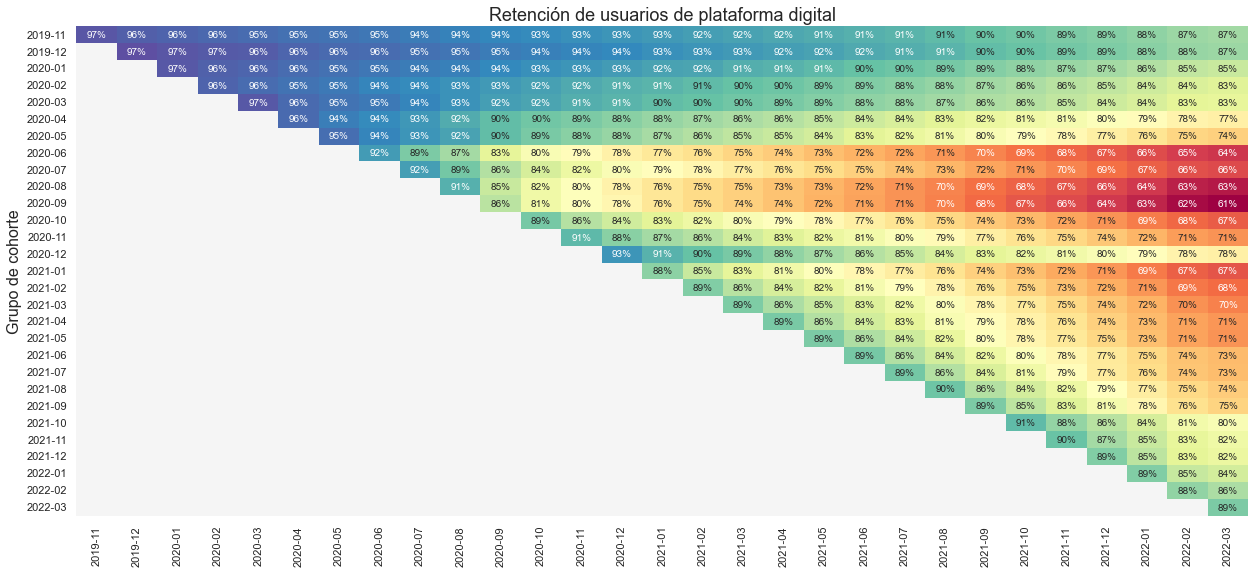

In [141]:
#Le damos las siguientes especificaciones a nuetros grafico.
plt.figure(figsize = (21, 9))
plt.title('Retención de usuarios de plataforma digital', fontsize = 18)
# Por si quiero formatear en % la escala de colores en caso de que la muestra
sns.set(font_scale=1)
ax = sns.heatmap(data=retencionp,
            annot=True,
            fmt='.0%',
            annot_kws={'size': 10},
            cbar=False,
            cmap = 'Spectral')

plt.ylabel('Grupo de cohorte', fontsize = 16)
plt.xlabel('')
ax.set_facecolor('whitesmoke')
plt.show()